Goals:
- Train GAN to more epochs and resize Monet images to get reasonable output of CycleGAN <--
- ProgressiveGAN: only upsampling + downsampling <--
  - ask if problems?

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import kagglehub
import torchvision.transforms as T
from torchvision.utils import make_grid
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm

In [2]:
to_tensor = T.ToTensor()

def load_image(path):
    return to_tensor(Image.open(path))


def show_images(imgs):
    # imgs is a tensor of shape: B x C x H x W
    grid = make_grid(imgs, nrow=4, padding=10, pad_value=1)
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.gcf().set_figwidth(8)
    plt.show()

In [3]:
class Monet(Dataset):
    def __init__(self, img_size=256):
        self.data_path = kagglehub.dataset_download(
            "dimitreoliveira/monet-paintings-jpg-berkeley")
        self.img_names = os.listdir(self.data_path)
        self.img_names = list(filter(lambda s: os.path.isfile(os.path.join(self.data_path, s)), self.img_names))

        # resize images to lower resolution
        print("Image size:", img_size)
        if img_size == 256:
            self.resized_data_path = self.data_path
        else:
            self.resized_data_path = os.path.join(self.data_path, f"resized_{img_size}")
        
        print("Saving resized images...")
        for img_name in tqdm(self.img_names):
            resized_path = os.path.join(self.resized_data_path, img_name)
            if os.path.exists(resized_path):
                continue

            # resize to specified img size
            orig_img_path = os.path.join(self.data_path, img_name)
            with Image.open(orig_img_path) as img:
                resized_img = img.resize((img_size, img_size))
                # save
                os.makedirs(os.path.dirname(resized_path), exist_ok=True)
                resized_img.save(resized_path)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, index):
        return load_image(os.path.join(self.resized_data_path, self.img_names[index]))


torch.Size([4, 3, 256, 256])


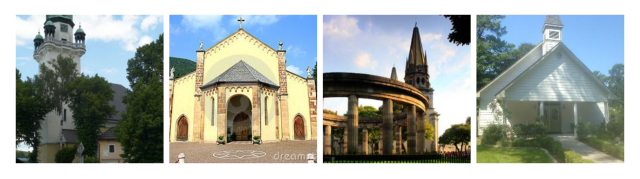

In [4]:
from torchvision.datasets import LSUN

# before running this, you need to download the lsun church outdoor images manually
# this takes around 10 minutes because the server is so slow
# mkdir lsun-church-outdoor
# git clone https://github.com/fyu/lsun
# cd lsun
# python3 download.py -c church_outdoor -o "../lsun-church-outdoor"
# then manually extract church_outdoor_train_lmdb.zip to church_outdoor_train_lmdb/, in the same directory
# you will also need to pip install lmdb

class LSUNChurch(Dataset):
    def __init__(self, img_size=256):
        self.img_size = img_size
        self.lsun_raw = LSUN("./lsun-church-outdoor", classes=["church_outdoor_train"], transform=to_tensor)

    def __getitem__(self, index):
        img = self.lsun_raw[index][0]  # [0] to get image only
        return T.CenterCrop(self.img_size)(img)
    
    def __len__(self):
        return len(self.lsun_raw)

imgs = next(iter(DataLoader(LSUNChurch(), batch_size=4, shuffle=True)))
print(imgs.shape)
show_images(imgs)

In [5]:
img_size = 256
monet = Monet(img_size)
lsun = LSUNChurch(img_size)

batch_size = 1
monet_loader = DataLoader(monet, batch_size=batch_size, shuffle=True)
lsun_loader = DataLoader(lsun, batch_size=batch_size, shuffle=True)

Image size: 256
Saving resized images...


100%|██████████| 1193/1193 [00:00<00:00, 14161.12it/s]


Define models

In [ ]:
from torch import nn
from torch.nn.utils.parametrizations import spectral_norm

class GeneratorResidualBlock(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.layers = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(n_channels, n_channels, kernel_size=3),
            nn.InstanceNorm2d(n_channels),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(n_channels, n_channels, kernel_size=3),
            nn.InstanceNorm2d(n_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return x + self.layers(x)


class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        layers = []

        # initial convolution
        layers += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, 64, kernel_size=7),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
        ]
        # downsample
        layers += [
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 128, kernel_size=3, stride=2),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 256, kernel_size=3, stride=2),
            nn.InstanceNorm2d(256),
            nn.ReLU(),
        ]
        # residual blocks
        for _ in range(6):
            layers.append(GeneratorResidualBlock(256))
        # upsample
        layers += [
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
        ]
        # final convolution
        layers += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, kernel_size=7),
            nn.Sigmoid()
        ]

        # put all the layers together
        self.layers = nn.Sequential(*layers)


    def forward(self, x):
        return self.layers(x)


class Discriminator(nn.Module):
    def __init__(self, input_channels=3):
        super().__init__()
        self.model = nn.Sequential(
            spectral_norm(nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)),
            # nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)),
            # nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1)),
            # nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # Output Layer: Conv -> Sigmoid
            spectral_norm(nn.Conv2d(512, 1, kernel_size=3, stride=1)),
            nn.Flatten(1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


Generated Images:


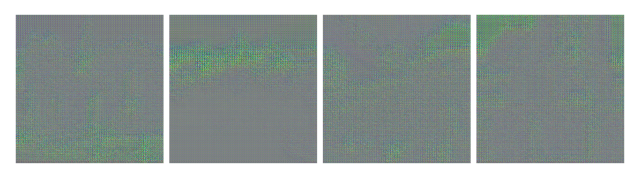

In [33]:
g = Generator()
d = Discriminator()

imgs = next(iter(lsun_loader))
fake_imgs = g(imgs)
print("Generated Images:")
show_images(fake_imgs[:8].detach().cpu())


In [32]:
import torch
import torch.optim as optim
from torch.autograd import Variable

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_epochs = 1
lr = 0.0002
lambda_cycle = 10
lambda_identity = 5

# Initialize models
generator_g = Generator().to(device)  # original img -> monet
generator_f = Generator().to(device)  # monet -> cifar

discriminator_x = Discriminator().to(device)  # For CIFAR
discriminator_y = Discriminator().to(device)  # For Monet

# Loss functions
adversarial_loss = nn.MSELoss()
cycle_loss = nn.L1Loss()
identity_loss = nn.L1Loss()

# Optimizers
optimizer_g = optim.Adam(list(generator_g.parameters()) + list(generator_f.parameters()), lr=lr, betas=(0.5, 0.999))
optimizer_dx = optim.Adam(discriminator_x.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_dy = optim.Adam(discriminator_y.parameters(), lr=lr, betas=(0.5, 0.999))

# Labels
real_label = 1.0
fake_label = 0.0

# Training loop
for epoch in range(num_epochs):
    for b, (real_x, real_y) in enumerate(zip(lsun_loader, monet_loader)):
        # Prepare data
        real_x = real_x[0].to(device)  # CIFAR images
        real_y = real_y.to(device)  # Monet images

        # -------------------------------------------
        #  Train Generators (G and F)
        # -------------------------------------------
        optimizer_g.zero_grad()

        # Adversarial loss
        fake_y = generator_g(real_x)  # X -> Y
        pred_fake_y = discriminator_y(fake_y)
        loss_g_adv = adversarial_loss(pred_fake_y, torch.ones_like(pred_fake_y).to(device))

        fake_x = generator_f(real_y)  # Y -> X
        pred_fake_x = discriminator_x(fake_x)
        loss_f_adv = adversarial_loss(pred_fake_x, torch.ones_like(pred_fake_x).to(device))

        # Cycle consistency loss
        cycle_x = generator_f(fake_y)  # X -> Y -> X
        loss_cycle_x = cycle_loss(cycle_x, real_x)

        cycle_y = generator_g(fake_x)  # Y -> X -> Y
        loss_cycle_y = cycle_loss(cycle_y, real_y)

        # Identity loss
        identity_x = generator_f(real_x)  # X -> X
        loss_id_x = identity_loss(identity_x, real_x)

        identity_y = generator_g(real_y)  # Y -> Y
        loss_id_y = identity_loss(identity_y, real_y)

        # Total generator loss
        loss_g = loss_g_adv + loss_f_adv + lambda_cycle * (loss_cycle_x + loss_cycle_y) + lambda_identity * (loss_id_x + loss_id_y)
        loss_g.backward()
        optimizer_g.step()

        # -------------------------------------------
        #  Train Discriminators (X and Y)
        # -------------------------------------------
        # Discriminator X
        optimizer_dx.zero_grad()

        pred_real_x = discriminator_x(real_x)
        loss_dx_real = adversarial_loss(pred_real_x, torch.ones_like(pred_real_x).to(device))

        pred_fake_x = discriminator_x(fake_x.detach())
        loss_dx_fake = adversarial_loss(pred_fake_x, torch.zeros_like(pred_fake_x).to(device))

        loss_dx = (loss_dx_real + loss_dx_fake) * 0.5
        loss_dx.backward()
        optimizer_dx.step()

        # Discriminator Y
        optimizer_dy.zero_grad()

        pred_real_y = discriminator_y(real_y)
        loss_dy_real = adversarial_loss(pred_real_y, torch.ones_like(pred_real_y).to(device))

        pred_fake_y = discriminator_y(fake_y.detach())
        loss_dy_fake = adversarial_loss(pred_fake_y, torch.zeros_like(pred_fake_y).to(device))

        loss_dy = (loss_dy_real + loss_dy_fake) * 0.5
        loss_dy.backward()
        optimizer_dy.step()

        print(f"Epoch [{epoch + 1}/{num_epochs}] Batch [{b + 1}/{len(monet_loader)}] | Loss G: {loss_g.item():.4f} | Loss DX: {loss_dx.item():.4f} | Loss DY: {loss_dy.item():.4f}")

    # print(f"Epoch [{epoch + 1}/{num_epochs}] | Loss G: {loss_g.item():.4f} | Loss DX: {loss_dx.item():.4f} | Loss DY: {loss_dy.item():.4f}")

# Save models
torch.save(generator_g.state_dict(), "generator_g.pth")
torch.save(generator_f.state_dict(), "generator_f.pth")
torch.save(discriminator_x.state_dict(), "discriminator_x.pth")
torch.save(discriminator_y.state_dict(), "discriminator_y.pth")


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 14.65 GiB is allocated by PyTorch, and 75.37 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

CIFAR Images


<ipython-input-17-e507038d838f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator_g.load_state_dict(torch.load("generator_g.pth"))
<ipython-input-17-e507038d838f>:4

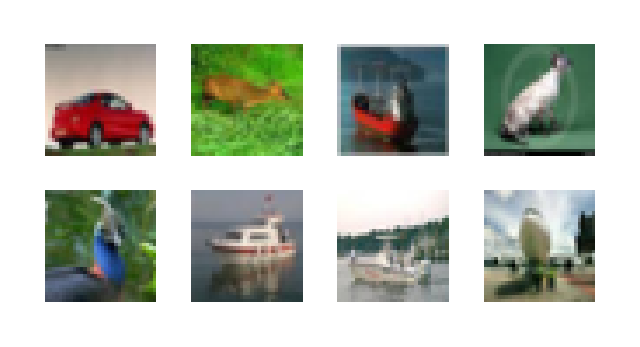

Generated Monet-style Images


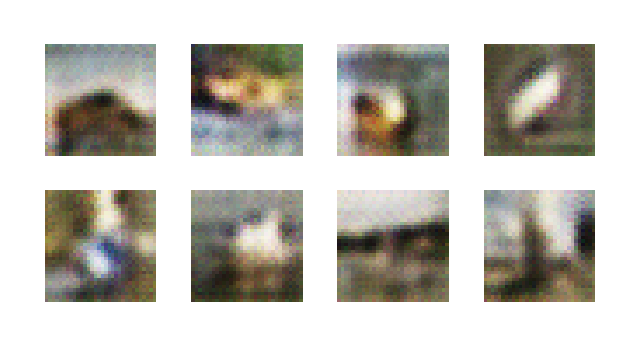

Reconstructed CIFAR Images


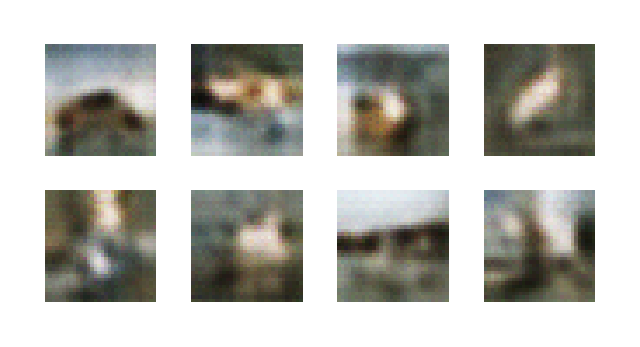

In [ ]:
# now let's test our cyclegan after training to see if it actually works:

generator_g.load_state_dict(torch.load("generator_g.pth"))
generator_f.load_state_dict(torch.load("generator_f.pth"))
generator_g.eval()
generator_f.eval()

real_x, _ = next(iter(lsun_loader))
real_x = real_x.cuda()

fake_y = generator_g(real_x).detach()
reconstructed_x = generator_f(fake_y).detach()

fake_y = fake_y.cpu()
reconstructed_x = reconstructed_x.cpu()

print("LSUN Images")
show_images(real_x[:8].cpu())
print("Generated Monet-style Images")
show_images(fake_y[:8])
print("Reconstructed LSUN Images")
show_images(reconstructed_x[:8])
